In [2]:
class CFG:
    DEBUG = False
    
    SEED = 1

    # classes
    NUM_CLASSES = 4
    CLASSES = ['holothurian', 'echinus', 'scallop', 'starfish']

    # training
    EPOCHS = 25
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8n'  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto'  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = 'D:/summer_intern/Dataset/URPC2020_detection'
    
    OUTPUT_DIR = 'D:/summer_intern/Dataset/URPC2020_detection'

In [3]:
import ultralytics
print(ultralytics.__version__)

8.2.49


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [5]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'subset_train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'subset_val'),
    
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [6]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- holothurian
- echinus
- scallop
- starfish
nc: 4
train: D:/summer_intern/Dataset/URPC2020_detection\subset_train
val: D:/summer_intern/Dataset/URPC2020_detection\subset_val



In [7]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

# Initialize dictionaries to store statistics
class_stat = {}
data_len = {}
class_info = []

# Iterate over dataset modes
for mode in ['subset_train', 'subset_val']:
    # Initialize class count for the current mode
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}
    
    # Path to the labels directory for the current mode
    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode,'labels')
    
    # Iterate over label files in the directory
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()
            
            # Increment the count for each unique class in the file
            for cls in set([line.split()[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    # Store data length and class count statistics
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count
    
    # Append information for the current mode
    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

# Create a DataFrame to store the statistics
dataset_stats_df = pd.DataFrame(class_info)
print(dataset_stats_df)

           Mode  holothurian  echinus  scallop  starfish  Data_Volume
0  subset_train          970     1500      795       954         2180
1    subset_val          233      372      206       218          547


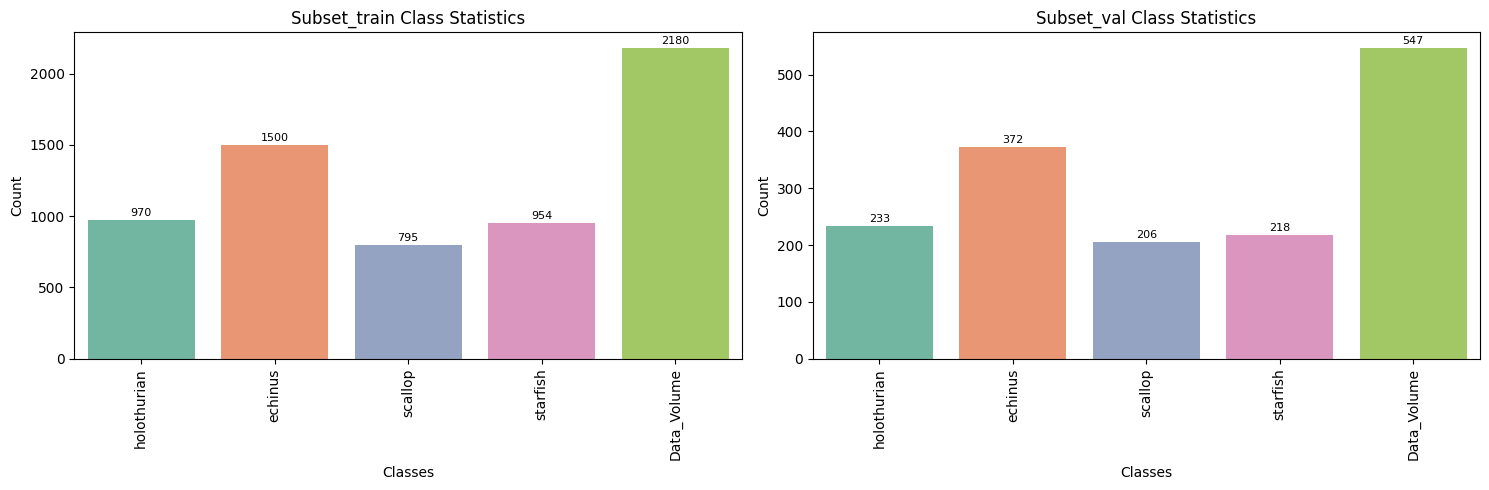

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming dataset_stats_df is already created

# Create subplots with 1 row and 2 columns for 'train' and 'val'
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['subset_train', 'subset_val']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


In [8]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)


Model:  yolov8n.pt
Epochs:  25
Batch:  16


In [9]:

img_properties = {
    'height': 500,
    'width': 500
}

In [10]:
# Load the model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [13]:
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    imgsz=(img_properties['height'], img_properties['width']),
    seed=CFG.SEED,
    
    workers=4,
    name=CFG.EXP_NAME,
   
)


New https://pypi.org/project/ultralytics/8.2.50 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/summer_intern/Dataset/URPC2020_detection\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=(500, 500), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=ppe_css_25_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

train: Scanning D:\summer_intern\Dataset\URPC2020_detection\subset_train\labels... 2180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2180/2180 [00:03<00:00, 634.53it/s]


train: New cache created: D:\summer_intern\Dataset\URPC2020_detection\subset_train\labels.cache


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\summer_intern\Dataset\URPC2020_detection\subset_val\labels... 547 images, 0 backgrounds, 0 corrupt: 100%|██████████| 547/547 [00:00<00:00, 674.98it/s]


val: New cache created: D:\summer_intern\Dataset\URPC2020_detection\subset_val\labels.cache
Plotting labels to runs\detect\ppe_css_25_epochs\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\ppe_css_25_epochs
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.966      2.533      1.294         47        512: 100%|██████████| 137/137 [1:03:47<00:00, 27.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:39<00:00,  8.86s/it]

                   all        547       4600      0.447      0.335      0.326      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.789      1.597      1.196         50        512: 100%|██████████| 137/137 [40:06<00:00, 17.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:52<00:00,  9.60s/it]

                   all        547       4600      0.541      0.461      0.467      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.746      1.488      1.184         75        512: 100%|██████████| 137/137 [25:32<00:00, 11.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:27<00:00,  4.86s/it]

                   all        547       4600      0.619      0.495      0.537      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.735      1.416      1.177         64        512: 100%|██████████| 137/137 [22:11<00:00,  9.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [04:41<00:00, 15.65s/it]

                   all        547       4600      0.632      0.536      0.581      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.687      1.337      1.162        103        512: 100%|██████████| 137/137 [30:51<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:41<00:00,  8.96s/it]

                   all        547       4600      0.643      0.551      0.608      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.652      1.271      1.143         60        512: 100%|██████████| 137/137 [22:59<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:56<00:00,  6.45s/it]

                   all        547       4600      0.664      0.557       0.61      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.645      1.228      1.139         14        512: 100%|██████████| 137/137 [20:47<00:00,  9.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:45<00:00,  5.84s/it]

                   all        547       4600      0.684      0.609      0.661      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.612      1.183      1.132         67        512: 100%|██████████| 137/137 [21:19<00:00,  9.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:37<00:00,  8.76s/it]

                   all        547       4600      0.676      0.608      0.654      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.604      1.152      1.115         44        512: 100%|██████████| 137/137 [29:20<00:00, 12.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:46<00:00,  9.28s/it]

                   all        547       4600      0.658        0.6      0.645      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.599       1.14      1.118         55        512: 100%|██████████| 137/137 [28:36<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [05:51<00:00, 19.54s/it]


                   all        547       4600      0.733      0.628      0.701      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.583      1.111       1.11         43        512: 100%|██████████| 137/137 [39:08<00:00, 17.14s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:40<00:00,  8.94s/it]

                   all        547       4600      0.723      0.645      0.706      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.564      1.093      1.104         69        512: 100%|██████████| 137/137 [33:52<00:00, 14.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [03:19<00:00, 11.07s/it]

                   all        547       4600      0.712      0.658      0.711       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.567      1.078        1.1         71        512: 100%|██████████| 137/137 [30:47<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:21<00:00,  7.87s/it]

                   all        547       4600      0.741      0.647      0.724      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.551      1.059      1.094         50        512: 100%|██████████| 137/137 [26:41<00:00, 11.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [03:05<00:00, 10.32s/it]

                   all        547       4600      0.737      0.642      0.711      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.549      1.051      1.098         65        512: 100%|██████████| 137/137 [18:01<00:00,  7.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:29<00:00,  4.99s/it]

                   all        547       4600      0.741      0.653      0.714      0.391


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G       1.52      1.044      1.099         10        512: 100%|██████████| 137/137 [17:53<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:29<00:00,  4.96s/it]

                   all        547       4600      0.723      0.642       0.71      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.498     0.9919      1.098         48        512: 100%|██████████| 137/137 [17:57<00:00,  7.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:29<00:00,  4.96s/it]

                   all        547       4600      0.744      0.656      0.735      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.477     0.9533      1.082         35        512: 100%|██████████| 137/137 [18:27<00:00,  8.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:30<00:00,  5.03s/it]

                   all        547       4600      0.773      0.661      0.746      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.469     0.9407      1.079         52        512: 100%|██████████| 137/137 [25:14<00:00, 11.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [03:13<00:00, 10.77s/it]

                   all        547       4600      0.757       0.68      0.751      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.466     0.9279      1.079         24        512: 100%|██████████| 137/137 [28:14<00:00, 12.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:56<00:00,  9.80s/it]

                   all        547       4600      0.775      0.675      0.754      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.448     0.9094      1.069         26        512: 100%|██████████| 137/137 [26:08<00:00, 11.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:54<00:00,  9.68s/it]

                   all        547       4600      0.768      0.687      0.757      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.432     0.8904      1.058         19        512: 100%|██████████| 137/137 [21:01<00:00,  9.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:28<00:00,  4.91s/it]

                   all        547       4600      0.761      0.693      0.765      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G      1.426      0.869      1.058         22        512: 100%|██████████| 137/137 [25:56<00:00, 11.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:11<00:00,  7.30s/it]

                   all        547       4600       0.79      0.697      0.773      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.412     0.8591      1.053         37        512: 100%|██████████| 137/137 [38:02<00:00, 16.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [04:08<00:00, 13.82s/it]

                   all        547       4600      0.785      0.695      0.774      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.399     0.8461      1.051         56        512: 100%|██████████| 137/137 [41:21<00:00, 18.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:38<00:00,  5.47s/it]

                   all        547       4600      0.777      0.703      0.776      0.445



25 epochs completed in 13.004 hours.
Optimizer stripped from runs\detect\ppe_css_25_epochs\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\ppe_css_25_epochs\weights\best.pt, 6.2MB

Validating runs\detect\ppe_css_25_epochs\weights\best.pt...
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:17<00:00,  4.29s/it]


                   all        547       4600      0.777      0.703      0.776      0.445
           holothurian        233        714      0.712      0.572       0.64      0.337
               echinus        372       1970      0.836      0.856      0.911      0.534
               scallop        206       1281      0.758      0.648      0.748      0.444
              starfish        218        635      0.803      0.735      0.807      0.465
Speed: 2.4ms preprocess, 94.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\ppe_css_25_epochs


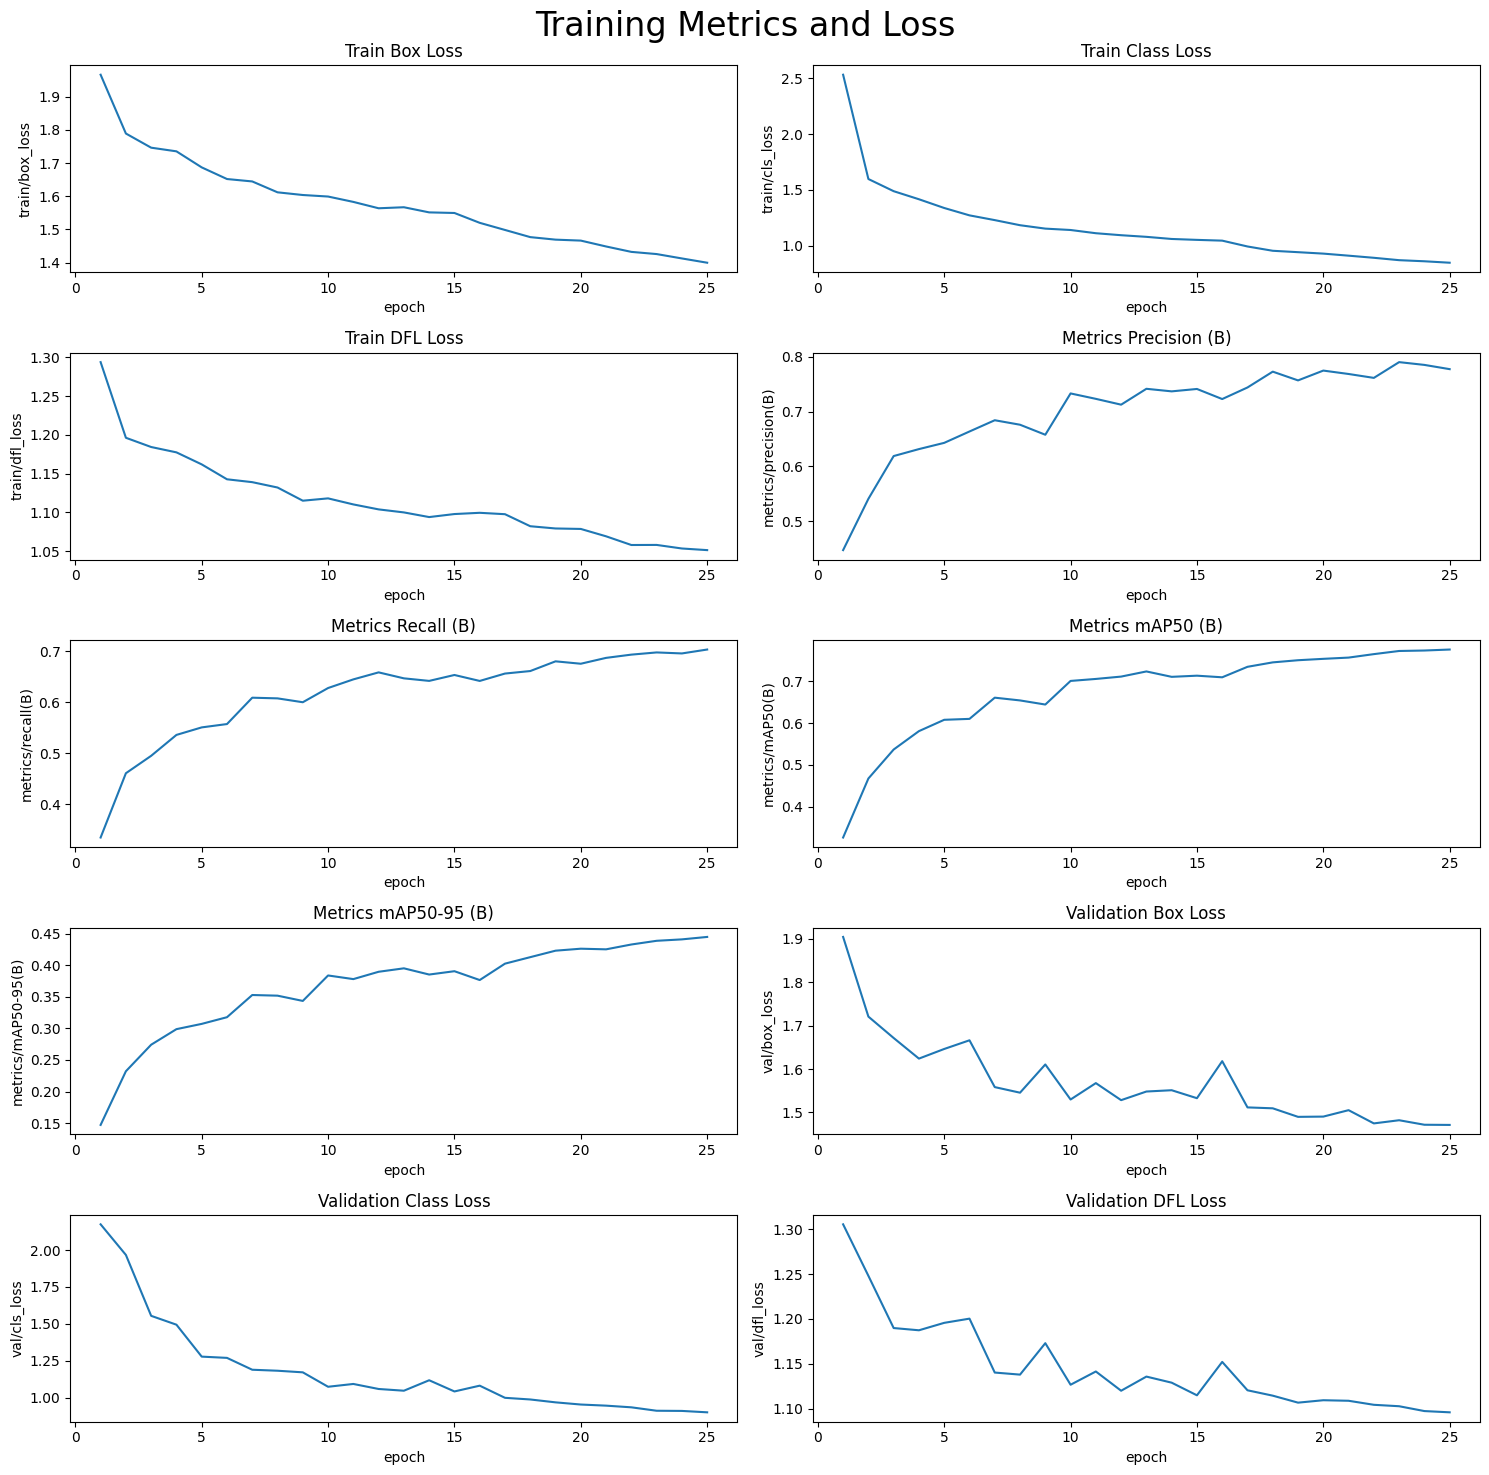

In [15]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('D:/summer_intern/runs/detect/ppe_css_25_epochs/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [11]:
#retrain use model best.pt for another 25 epoch
model = YOLO('D:/summer_intern/runs/detect/ppe_css_25_epochs/weights/best.pt')
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    imgsz=(img_properties['height'], img_properties['width']),
    seed=CFG.SEED,
    
    workers=4,
    name=CFG.EXP_NAME,
   
)


New https://pypi.org/project/ultralytics/8.2.51 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=D:/summer_intern/runs/detect/ppe_css_25_epochs/weights/best.pt, data=D:/summer_intern/Dataset/URPC2020_detection\data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=(500, 500), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=ppe_css_25_epochs2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning D:\summer_intern\Dataset\URPC2020_detection\subset_train\labels.cache... 2180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2180/2180 [00:00<?, ?it/s]
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\summer_intern\Dataset\URPC2020_detection\subset_val\labels.cache... 547 images, 0 backgrounds, 0 corrupt: 100%|██████████| 547/547 [00:00<?, ?it/s]


Plotting labels to runs\detect\ppe_css_25_epochs2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\ppe_css_25_epochs2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.487     0.9582      1.066         47        512: 100%|██████████| 137/137 [30:27<00:00, 13.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:43<00:00,  9.06s/it]

                   all        547       4600       0.75      0.672      0.742      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.514     0.9942      1.075         50        512: 100%|██████████| 137/137 [27:55<00:00, 12.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:29<00:00,  8.30s/it]

                   all        547       4600      0.725      0.665      0.717      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.536      1.034       1.09         75        512: 100%|██████████| 137/137 [17:31<00:00,  7.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.66s/it]

                   all        547       4600       0.71      0.638      0.703      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.573      1.053      1.103         64        512: 100%|██████████| 137/137 [16:37<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.66s/it]

                   all        547       4600      0.743      0.655      0.725      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.523      1.015      1.089        103        512: 100%|██████████| 137/137 [16:37<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.68s/it]

                   all        547       4600      0.764      0.613       0.71      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.511      1.003       1.08         60        512: 100%|██████████| 137/137 [16:33<00:00,  7.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.67s/it]

                   all        547       4600       0.76      0.636      0.719      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.517     0.9966      1.082         14        512: 100%|██████████| 137/137 [16:36<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:25<00:00,  4.73s/it]

                   all        547       4600      0.743      0.648      0.726      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.496     0.9822       1.08         67        512: 100%|██████████| 137/137 [16:38<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.65s/it]

                   all        547       4600      0.733      0.657      0.723      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.489     0.9654      1.067         44        512: 100%|██████████| 137/137 [16:31<00:00,  7.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.67s/it]

                   all        547       4600      0.757      0.643       0.73      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.492     0.9673      1.073         55        512: 100%|██████████| 137/137 [16:31<00:00,  7.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.66s/it]

                   all        547       4600       0.76      0.673      0.748      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.474     0.9402      1.066         43        512: 100%|██████████| 137/137 [16:36<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.67s/it]

                   all        547       4600       0.77      0.662      0.751      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.475      0.933      1.066         69        512: 100%|██████████| 137/137 [16:35<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.65s/it]

                   all        547       4600      0.776      0.681      0.756      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.468     0.9246      1.062         71        512: 100%|██████████| 137/137 [16:36<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.63s/it]

                   all        547       4600      0.767      0.687      0.755      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.462     0.9159      1.057         50        512: 100%|██████████| 137/137 [24:26<00:00, 10.70s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:19<00:00,  7.77s/it]

                   all        547       4600      0.767      0.669      0.754      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.451     0.9064       1.06         65        512: 100%|██████████| 137/137 [27:05<00:00, 11.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:29<00:00,  8.28s/it]

                   all        547       4600      0.787      0.674      0.757      0.425


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.421     0.8834       1.06         10        512: 100%|██████████| 137/137 [25:26<00:00, 11.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:31<00:00,  8.44s/it]

                   all        547       4600      0.759      0.693      0.759      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.406     0.8469      1.059         48        512: 100%|██████████| 137/137 [25:59<00:00, 11.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:25<00:00,  8.08s/it]

                   all        547       4600      0.771      0.697       0.77      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.385      0.817      1.047         35        512: 100%|██████████| 137/137 [25:50<00:00, 11.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:27<00:00,  8.18s/it]

                   all        547       4600      0.787      0.691      0.777      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.385     0.8061      1.045         52        512: 100%|██████████| 137/137 [25:36<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:24<00:00,  8.03s/it]

                   all        547       4600      0.791      0.697       0.78      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.378     0.7998      1.045         24        512: 100%|██████████| 137/137 [24:23<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [03:55<00:00, 13.10s/it]

                   all        547       4600      0.794      0.706      0.787      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.355     0.7857      1.034         26        512: 100%|██████████| 137/137 [2:50:26<00:00, 74.64s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:25<00:00,  4.77s/it]

                   all        547       4600      0.795      0.718       0.79      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.348     0.7748      1.027         19        512: 100%|██████████| 137/137 [16:17<00:00,  7.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.70s/it]

                   all        547       4600      0.799      0.717      0.791      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G      1.344     0.7608      1.028         22        512: 100%|██████████| 137/137 [16:15<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:24<00:00,  4.68s/it]

                   all        547       4600      0.796       0.72      0.792      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.335     0.7567      1.025         37        512: 100%|██████████| 137/137 [16:14<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.67s/it]

                   all        547       4600      0.793      0.724      0.794      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.323     0.7487      1.023         56        512: 100%|██████████| 137/137 [16:13<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:23<00:00,  4.67s/it]

                   all        547       4600      0.811      0.712      0.795      0.461



25 epochs completed in 11.711 hours.
Optimizer stripped from runs\detect\ppe_css_25_epochs2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\ppe_css_25_epochs2\weights\best.pt, 6.2MB

Validating runs\detect\ppe_css_25_epochs2\weights\best.pt...
Ultralytics YOLOv8.2.49  Python-3.11.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [01:05<00:00,  3.62s/it]


                   all        547       4600      0.812      0.711      0.795       0.46
           holothurian        233        714       0.75      0.591      0.661      0.358
               echinus        372       1970      0.857      0.856      0.918      0.543
               scallop        206       1281      0.813      0.677      0.788      0.473
              starfish        218        635      0.827       0.72      0.814      0.467
Speed: 1.5ms preprocess, 79.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\ppe_css_25_epochs2


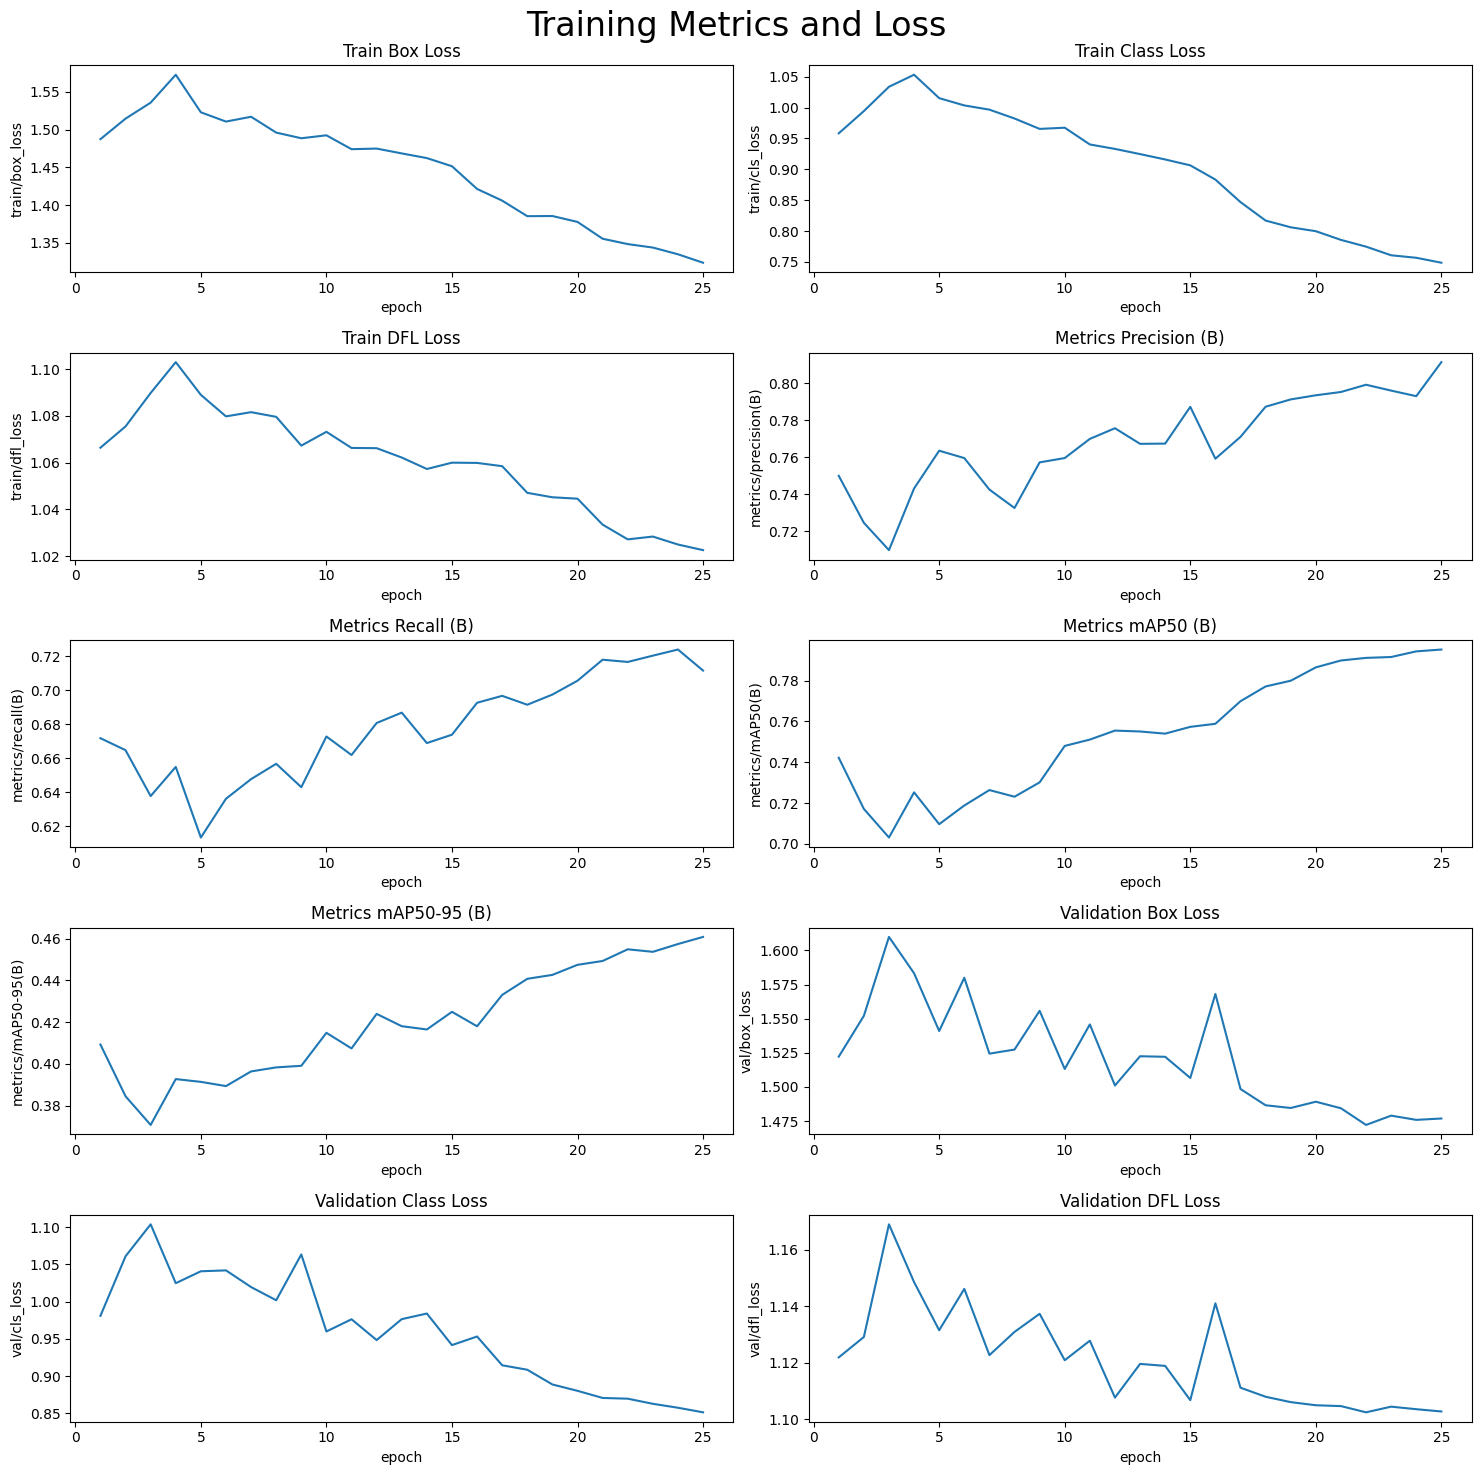

In [12]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('D:/summer_intern/runs/detect/ppe_css_25_epochs2/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()